In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

# plotting params
%matplotlib inline
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.figsize'] = (13.0, 6.0)
sns.set_style("white")

data_dir = './data/'
plot_dir = './imgs/'
dump_dir = './dump/'

## Setup

In [2]:
# ensuring reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = False

In [3]:
GPU = False

device = torch.device("cuda" if GPU else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if GPU else {}

## Data Loader

In [ ]:
# make sure shuffling is turned off
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_dir, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=False, **kwargs)

## Model

In [ ]:
class SmallConv(nn.Module):
    def __init__(self):
        super(SmallConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        out = F.relu(F.max_pool2d(self.conv1(x), 2))
        out = F.relu(F.max_pool2d(self.conv2(out), 2))
        out = out.view(-1, 320)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return F.log_softmax(out, dim=1)

## Utility Functions

In [ ]:
def accumulate_gradient(losses, model):
    """Computes the L2 norm of the gradient of the loss 
    with respect to the weights and biases of the network.
    
    Since there's a weight and bias vector associated with 
    every convolutional and fully-connected layer, the square
    root of the sum of the squared gradient norms is returned.
    """
    norms = []
    for l in losses:
        grad_params = torch.autograd.grad(l, model.parameters(), create_graph=True)
        grad_norm = 0
        for grad in grad_params:
            grad_norm += grad.norm(2).pow(2)
        norms.append(grad_norm.sqrt())
    return norms

def accuracy(predicted, ground_truth):
    predicted = torch.max(predicted, 1)[1]
    total = len(ground_truth)
    correct = (predicted == ground_truth).sum().double()
    acc = 100 * (correct / total)
    return acc.item()

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    
    epoch_stats = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # forward pass
        output = model(data)
        acc = accuracy(output, target)
        
        # compute batch loss and gradient norm
        losses = F.nll_loss(output, target, reduction='none')
        grad_norms = accumulate_gradient(losses, model)
        indices = [batch_idx*len(data) + i for i in range(len(data))]
        
        batch_stats = []
        for i, g, l in zip(indices, grad_norms, losses):
            batch_stats.append([i, [g, l]])
        epoch_stats.append(batch_stats)
            
        # take average loss and accuracy
        loss = losses.mean()
        
        # backwards pass
        loss.backward()
        optimizer.step()
        
        if batch_idx % 25 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
100. * batch_idx / len(train_loader), loss.item(), acc))

    return epoch_stats

## Main Logic

In [ ]:
model = SmallConv().to(device)

# relu init
for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_in')

# define optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

num_epochs = 1

stats = []
for epoch in range(1,  num_epochs+1):
    stats.append(train(model, device, train_loader, optimizer, epoch))

In [ ]:
pickle.dump(stats, open(dump_dir + "statistics.pkl", "wb"))

## Plot

In [4]:
stats = pickle.load(open(dump_dir + "statistics.pkl", "rb"))

In [5]:
def loss_vs_gradnorm(list_stats):
    flattened = [val for sublist in list_stats for val in sublist]
    sorted_idx = sorted(range(len(flattened)), key=lambda k: flattened[k][1][0])
    losses = [flattened[idx][1][1].item() for idx in sorted_idx]
    return losses

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

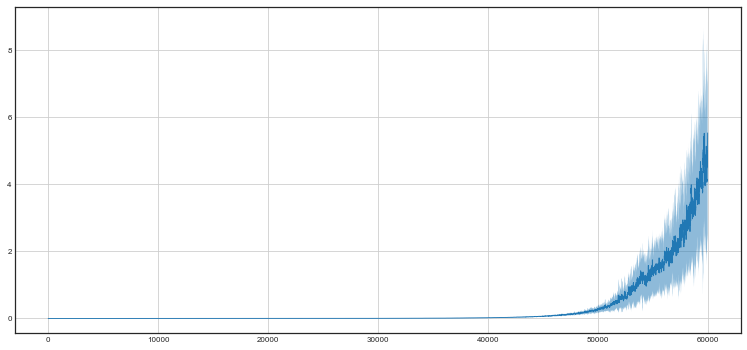

In [6]:
sorted_losses = np.array(loss_vs_gradnorm(stats[0]))

fig, ax = plt.subplots(figsize=(13, 6))

rolling_mean = np.mean(rolling_window(sorted_losses, 50), 1)
rolling_std = np.std(rolling_window(sorted_losses, 50), 1)

plt.plot(range(len(rolling_mean)), rolling_mean, alpha=0.98, linewidth=0.9)
plt.fill_between(range(len(rolling_std)), rolling_mean-rolling_std, rolling_mean+rolling_std, alpha=0.5)

plt.grid()
plt.savefig(plot_dir + "loss_vs_grad.jpg", format="jpg", dpi=250, bbox_inches='tight')
plt.show()